<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/food_habits_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food habits analytics

## Uploading packages and data

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd

In [22]:
#Uploading google sheet data from drive
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

#Loading dataset from google sheet
wb1 = gc.open('food_habits')
ws1_data = wb1.sheet1
records_1 = ws1_data.get_all_records()

# Converting to a Pandas DataFrame
df1 = pd.DataFrame.from_records(records_1)
df1.tail(3)

,food,large_meal,ache,event
105,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-08 19:40:00
106,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-15 21:00:00
107,"yogurt, oat, milk, pear, honey, raisins, banan...",1,1,2021-12-18 17:00:00


In [23]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   food        108 non-null    object
 1   large_meal  108 non-null    int64 
 2   ache        108 non-null    int64 
 3   event       108 non-null    object
dtypes: int64(2), object(2)
memory usage: 3.5+ KB


##Data Manipulation

In [24]:
#Converting date columns to datetime objects
df1['event'] = pd.to_datetime(df1['event'], format='%Y-%m-%d %H:%M:%S')

In [25]:
#Extracting year, month, day of the week, hour and count of ingredients
df1 = df1.assign(year = df1['event'].dt.year,
                 month = df1['event'].dt.month,
                 day = df1['event'].dt.dayofweek,
                 hour = df1['event'].dt.hour,
                 ing_count = [len(i.split(', ')) for i in df1['food']])
df1.tail(3)

,food,large_meal,ache,event,year,month,day,hour,ing_count
105,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-08 19:40:00,2021,12,2,19,19
106,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-15 21:00:00,2021,12,2,21,16
107,"yogurt, oat, milk, pear, honey, raisins, banan...",1,1,2021-12-18 17:00:00,2021,12,5,17,21


In [85]:
#Filtering the dataframe and assigning categories for 2021 where stomach ache appeared
df1_2021 = df1[(df1['year']==2021) & (df1['ache']==1)].reset_index(drop=True)
df1_2021 = df1_2021.assign(cat = np.select(condlist=[(df1_2021['month']<6), ((df1_2021['month']>=6) & (df1_2021['month']<10)), (df1_2021['month']==10),
                                                    (df1_2021['month']>=11)], choicelist=['milk_diet', 'lactose_free', 'rotavirus', 'post_virus']))
df1_2021.tail(2)

,food,large_meal,ache,event,year,month,day,hour,ing_count,cat
59,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-15 21:00:00,2021,12,2,21,16,post_virus
60,"yogurt, oat, milk, pear, honey, raisins, banan...",1,1,2021-12-18 17:00:00,2021,12,5,17,21,post_virus


In [87]:
#Calculating range of days between events and converting to int (days)
df1_2021 = df1_2021.assign(event_2 = df1_2021['event'].shift(fill_value=np.nan))
df1_2021 = df1_2021.assign(num_of_days = (df1_2021['event'] - df1_2021['event_2']))
df1_2021 = df1_2021.assign(num_of_days = df1_2021['num_of_days'].replace(np.nan, 0))
df1_2021 = df1_2021.assign(num_of_days = (df1_2021['num_of_days'].astype(int))/8.64e+13) #==> Converting from ns to days
df1_2021.tail(3)

,food,large_meal,ache,event,year,month,day,hour,ing_count,cat,event_2,num_of_days
58,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-08 19:40:00,2021,12,2,19,19,post_virus,2021-12-01 17:30:00,7.090278
59,"yogurt, oat, milk, pear, honey, raisins, bread...",1,1,2021-12-15 21:00:00,2021,12,2,21,16,post_virus,2021-12-08 19:40:00,7.055556
60,"yogurt, oat, milk, pear, honey, raisins, banan...",1,1,2021-12-18 17:00:00,2021,12,5,17,21,post_virus,2021-12-15 21:00:00,2.833333


In [88]:
#Calculating porcentage of change between stomach ache events
df1_2021 = df1_2021.assign(pct_days = df1_2021['num_of_days'].pct_change())
df1_2021 = df1_2021.assign(pct_days = df1_2021['pct_days'].replace(np.nan, 0))

In [89]:
#Replacing int days for name days
days_dict = {0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df1_2021['day'] = df1_2021['day'].replace(to_replace=days_dict)

In [90]:
#Counting the proportion of stomach aches by the day of the week
df1_2021['day'].value_counts(normalize=True)

Fri    0.213115
Sun    0.180328
Wed    0.163934
Thu    0.147541
Tue    0.114754
Sat    0.098361
Mon    0.081967
Name: day, dtype: float64

In [91]:
#Counting the proportion of stomach aches by hour of the day
df1_2021['hour'].value_counts(normalize=True)

17    0.196721
19    0.163934
20    0.114754
18    0.114754
21    0.098361
16    0.081967
22    0.049180
2     0.049180
15    0.032787
8     0.032787
14    0.016393
13    0.016393
10    0.016393
7     0.016393
Name: hour, dtype: float64

In [92]:
#Transforming aching meals into list
ache_1 = df1[df1['ache']==1]['food'].str.cat(sep=', ').split(", ")
ache_1[:5]

['bread', 'pepperoni', 'ham', 'cheese', 'ricotta']

In [93]:
#Building a dictionary of occurrences for each food
import collections
ache_occurrences = collections.Counter(ache_1)
ache_occurrences.get('bread')

25

In [94]:
#Transforming list of aching meals into series
ache_meal_1 = pd.Series(data=ache_1)
ache_meal_1.tail()

876          rice
877          meat
878    red_pepper
879         onion
880       avocado
dtype: object

In [95]:
#Counting top foods in diet
ache_meal_1 = ache_meal_1.value_counts().reset_index(name='count').rename(columns={'index':'food'})
ache_meal_1.head()

,food,count
0,rice,47
1,cheese,37
2,bread,25
3,yogurt,22
4,chicken,22


In [ ]:
#Exporting to excel into local disk
#from google.colab import files
#ache_meal_1.to_excel('food_count.xlsx', index=False) #==> Excluding index from file
#files.download('food_count.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Visualization

In [96]:
#Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (10, 4)})

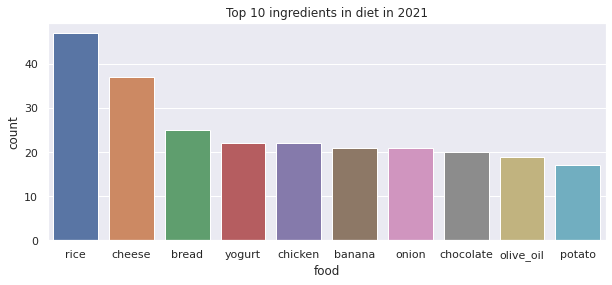

In [98]:
#Plotting the top 10 ingredients in diet
sns.barplot(x='food', y='count', data=ache_meal_1[:10])
plt.title('Top 10 ingredients in diet in 2021')
plt.show()

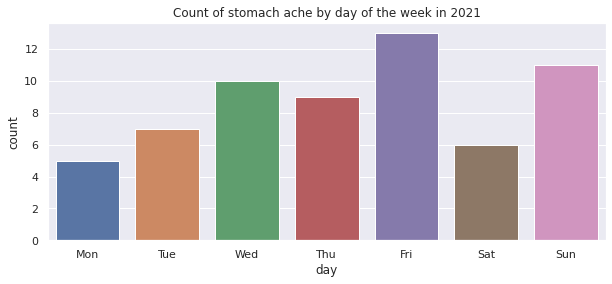

In [99]:
#Plotting the number of stomach ache by day of the week
sns.countplot(x='day', data=df1_2021, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Count of stomach ache by day of the week in 2021')
plt.show()

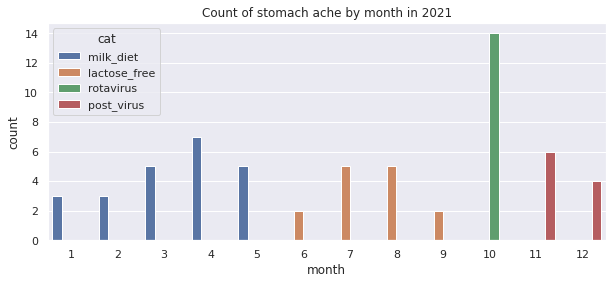

In [100]:
#Plotting the number of stomach ache by month
sns.countplot(x='month', data=df1_2021, hue='cat')
plt.title('Count of stomach ache by month in 2021')
plt.show()

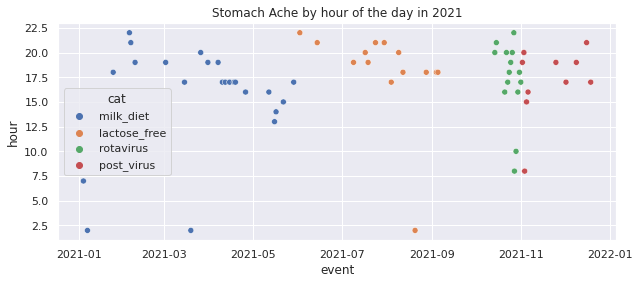

In [101]:
#Plotting the percentage of change between stomache ache events
sns.scatterplot(x='event', y='hour', data=df1_2021, hue='cat')
plt.title('Stomach Ache by hour of the day in 2021')
plt.show()

###Variability graphs

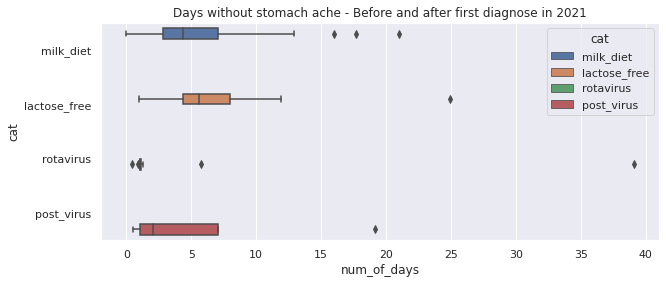

In [102]:
#Plotting the boxplot of days between stomach ache
sns.boxplot(x='num_of_days', y='cat', data=df1_2021, hue='cat')
plt.title('Days without stomach ache - Before and after first diagnose in 2021')
plt.show()

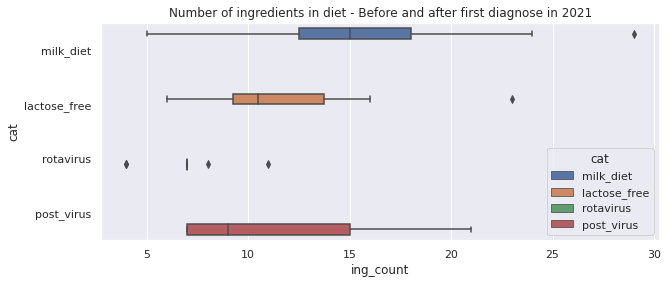

In [103]:
#Plotting the boxplot of number of ingredients present in diet
sns.boxplot(x='ing_count', y='cat', data=df1_2021, hue='cat')
plt.title('Number of ingredients in diet - Before and after first diagnose in 2021')
plt.show()

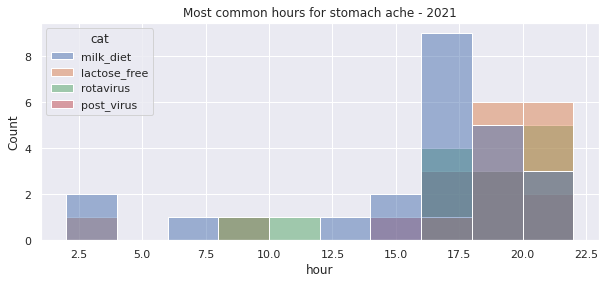

In [104]:
#Plotting the histogram of hours for stomach ache
sns.histplot(x='hour', data=df1_2021, hue='cat')
plt.title('Most common hours for stomach ache - 2021')
plt.show()